In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets,transforms,models
# nn is the pytorch nueral network model.
# optim is the pytroch optimizer. This is optimizes the model.
# dataloader is for reading and processing different datasets.
# torchvision is the module for image processing.

In [ ]:
input_size = 80
# The model input size should always be fixed. Input_size sets the image size to 80x80 pixels.

device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
# This checks if the gpu is available, if not it will use cpu. GPU is faster.
# In the runtime tab, I've changed the "runtime type" to "T4 GPU4". This is faster for training the model.

In [ ]:
device
#If you run this cell and it prints "cuda" that means GPU is available.
#Otherwise it will print "CPU"

device(type='cuda')

In [ ]:
transform=transforms.Compose([transforms.Resize((80,80)),transforms.ToTensor(),transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
# transforms.Resize changes the size of the image
# transforms.ToTensor converts the 80x80 image to Tensor. a tensor is a multidimentional array/matrix
# transforms.Normalize. This normalizes the pixels values based on the parameters we provide.

In [ ]:
dataset=datasets.ImageFolder("/content/drive/MyDrive/Dataset_BUSI_with_GT",transform=transform)
#Here we are loading the image folder from the google drive directory.
#We are also passing in the transform parameter, which will run the operations listed in the previous cell.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
#Here we are just mounting the google drive where the images are stored.

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
train_size = int(0.8*len(dataset))
#Here we are taking 80% of the dataset for training.

In [ ]:
test_size = len(dataset)-train_size
#Here we are assigning the remaining 20% for testing.

In [ ]:
train_dataset,test_dataset=torch.utils.data.random_split(dataset,[train_size,test_size])
#Now we are splitting the dataset with train_dataset
#We are passing in the size train_size and test_size

In [ ]:
train_loader=DataLoader(train_dataset,batch_size=32,shuffle=True)
test_loader=DataLoader(test_dataset,batch_size=32,shuffle=True)
#Here we are defining how many images to push to the model in each time (each iteration).
#We will push 32 images at each instance, and shuffle them so we don't push the same image into the model.
#We can decrease the batch size if we want to use less memory (will take longer). Or increase it if we have memory and want to train fast.

In [ ]:
# instance=iter(train_loader)
# images,labels=next(instance)
# image=images[0]
# label=labels[0]
# image=image.permute(1,2,0)
# plt.imshow(image)
# plt.title(label)
# plt.show()

In [ ]:
model=models.resnet18(pretrained=True)
#Here we will define the model.
#This will load the pretrained model
#Resnet 18 is a model architecture.

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 77.7MB/s]


In [ ]:
#print(model)
#Here we can print out the model to see what it looks like (resnet)

In [ ]:
model.fc=nn.Linear(model.fc.in_features,3)
#We have 3 classes.
#Since our images are grouped in three classes, we will check the probability of each class (normal, benign, and malignant)
#This is why it's called a classification model.

In [ ]:
model=model.to(device)
#Here we will set it to run the model on the device.
#When we use GPU or CPU in Pytorch we have to convert the model.
#The device parameter means we are using GPU (cuda)
#This can be validated above where we call (device) and see "cuda" printed.

In [ ]:
loss_fn=nn.CrossEntropyLoss()
#Loss Function
#This loss function calculates the deviation value.
#Ths will calculate the deviations of the predicted data from the actual data.

In [ ]:
optimizer=optim.Adam(model.parameters(),0.001)
#Here we will set the learning rate to 0.001 for the optimizer
#The optimizer is responsible for adjusting the neuron values, so the model can improve it's accuracy.

In [ ]:
#Here we are defining the function to train the model.
#We will pass in the required parameters which we've created

def train_model(model, train_loader, val_loader, criterion, optimizer, epochs):
    train_acc_history = []
    val_acc_history = []
    train_loss_history = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        # Training loop
        for inputs, labels in train_loader:
            #Here we are converting the image data to GPU
            inputs, labels = inputs.to(device), labels.to(device)
            #Initialize the optimizer
            optimizer.zero_grad()
            #Push the model inputs to the model, to get the output
            outputs = model(inputs)
            # Then we are converting the output value from the model to the actual value.
            #The loss function is an important function to solve this problem.
            loss = criterion(outputs, labels)
            #This is the backward propagation (.backward and .step). After calculating the loss it will update the values of the nuerons.
            #This is one of th most important parts of the nueral network.
            loss.backward()
            optimizer.step()

            #This is summing the loss for each run.
            running_loss += loss.item()
            #This is the predicted output (torch.max)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_acc = correct / total
        train_acc_history.append(train_acc)

        # Validation loop
        # .eval evaluates how well the model performed on the test data set.
        model.eval()
        val_correct = 0
        val_total = 0

        #Here we are not updating the model parameters with no_grad.
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_acc = val_correct / val_total
        val_acc_history.append(val_acc)
        train_loss_history.append(running_loss/len(train_loader))
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader):.4f}, "
              f"Train Accuracy: {train_acc:.4f}, Validation Accuracy: {val_acc:.4f}")

    return train_acc_history, val_acc_history,train_loss_history

# Train the model
# Here we are calling the function.
# Here we are setting the number of epochs to 10
# Here we are passing in the loss function
train_acc_history, val_acc_history,train_loss_history = train_model(model, train_loader, test_loader, loss_fn, optimizer, 10)

# Save the trained model
torch.save(model.state_dict(), 'multi_class_classification_model.pth')

Epoch [1/10], Loss: 0.0648, Train Accuracy: 0.9794, Validation Accuracy: 0.9019
Epoch [2/10], Loss: 0.0708, Train Accuracy: 0.9762, Validation Accuracy: 0.9019
Epoch [3/10], Loss: 0.0891, Train Accuracy: 0.9691, Validation Accuracy: 0.8671
Epoch [4/10], Loss: 0.0772, Train Accuracy: 0.9739, Validation Accuracy: 0.8481
Epoch [5/10], Loss: 0.0424, Train Accuracy: 0.9842, Validation Accuracy: 0.8892
Epoch [6/10], Loss: 0.0293, Train Accuracy: 0.9905, Validation Accuracy: 0.9114
Epoch [7/10], Loss: 0.0314, Train Accuracy: 0.9937, Validation Accuracy: 0.9146
Epoch [8/10], Loss: 0.0203, Train Accuracy: 0.9937, Validation Accuracy: 0.9019
Epoch [9/10], Loss: 0.0228, Train Accuracy: 0.9929, Validation Accuracy: 0.8987
Epoch [10/10], Loss: 0.0237, Train Accuracy: 0.9913, Validation Accuracy: 0.8987


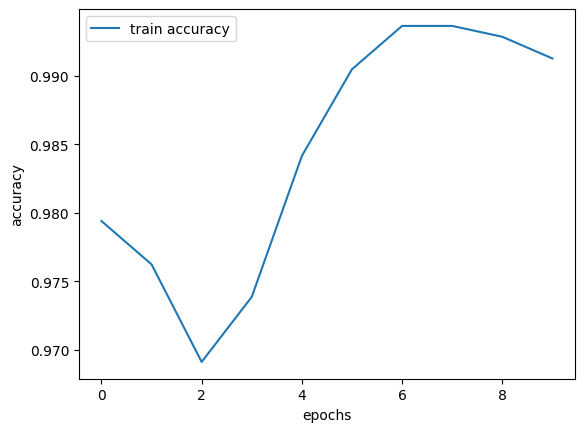

In [ ]:
import matplotlib.pyplot as plt
plt.plot(train_acc_history,label="train accuracy")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend()
plt.show()
# This plot will show the accuracy of the model for each epoch
# The training accuracy measures how well the model is able to classify the images during the training phase

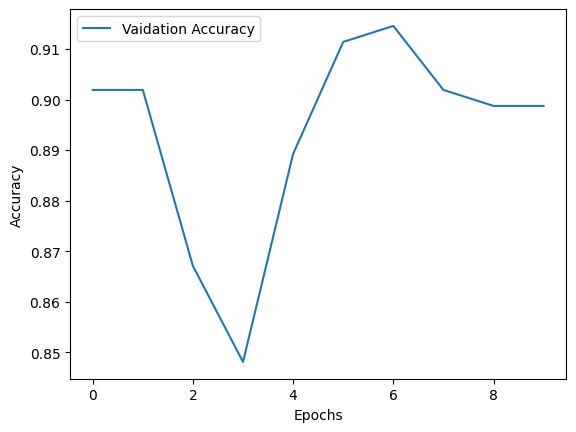

In [ ]:
plt.plot(val_acc_history,label="Vaidation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()
# This chart shows the validation accuracy by epoch.
# The validation accuracy measures how well the model is able to classify the images during the valdiation phase

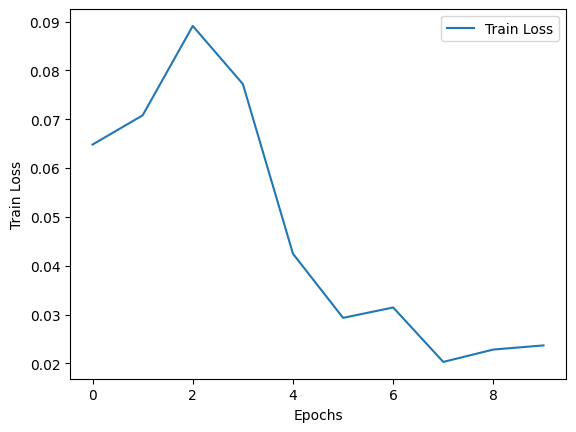

In [ ]:
plt.plot(train_loss_history,label="Train Loss")
plt.xlabel("Epochs")
plt.ylabel("Train Loss")
plt.legend()
plt.show()
# The train loss chart shows how much discrprency there is between the actual output and the predicted output.

In [ ]:
#Analyzing the results.
#If our loss score is decreasing with each epoch, that is good and means our model is predicting more accurately.
#If our accuracy is increasing that is good and means the model is improving